In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
# from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
import os
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import warnings
## check for a GPU
if not tf.test.gpu_device_name():
  warnings.warn('No GPU found.....')
#sys.exit()
else:
  print('Default GPU device :{}'.format(tf.test.gpu_device_name()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: No GPU found.....
  app.launch_new_instance()


In [7]:
class scan():
  '''
  This is the main class for activating all the models.
  The user has only to choose which model he/she wants with all the hyperparameters are under his/her
  control.
   To be done:
   1- The input shape still has to be generalized to include thhe higher dimensions scan.
   2- Link this class with the main scanner package (SPheno+HS+HB+MO+MG)
  '''
  def obs(self,x1,x2):
    'To be replaced with the HEP packge'
    F = (2+np.cos(x1/2)*np.cos(x2/2))**5
    return np.array(F)
  def generate_init(self,n):
    x1,x2=[],[]
    for q in range(n):
      x1.append(np.random.uniform(0,10*np.pi))
      x2.append(np.random.uniform(0,10*np.pi))
    return np.array(x1),np.array(x2),np.array([x1,x2]).T

  def likelihood(self,exp_value,std,th):
    ll = np.exp(- (exp_value - th)**2/(2*std**2))
    return ll

  def run_DNN(self,runs=20,neurons = 100,activation='relu',epoch=1000,print_output=True):
    dnn = Sequential()
    dnn.add(Dense(neurons, input_shape=(2,)))
    dnn.add(Dense(neurons, activation=activation))
    dnn.add(Dense(neurons, activation=activation))
    dnn.add(Dense(neurons, activation=activation))
    dnn.add(Dense(neurons, activation=activation))
    dnn.add(Dense(1))

    dnn.compile(optimizer='adam', loss='mse')    
    x1,x2,X=self.generate_init(100)
    obs1 = self.obs(x1, x2)
    dnn.fit(X, obs1, epochs=epoch, verbose=0)
    for q in range(runs):
      _,_,x = self.generate_init(10000)
      pred = dnn.predict(x).flatten()
      pred1 = self.likelihood(100,20,pred)
      xsel = x[pred1>0.9]
      xsel1 = np.append(xsel[:90],x[-10:],axis=0)
      obs2 = self.obs(xsel1[:, 0], xsel1[:, 1])
      X = np.append(X, xsel1, axis=0)
      obs1 = np.append(obs1, obs2)
      dnn.fit(X, obs1,epochs=epoch, batch_size=500,verbose=0)
      if print_output == True:
          print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
    return X

  def run_GBR(self,runs =20,learning_rate=0.01,n_estimators=50,max_depth=30,print_output=True):
    GBR =GradientBoostingRegressor(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
    x1,x2,X=self.generate_init(100)
    obs1 = self.obs(x1, x2)
    GBR.fit(X, obs1)
    for q in range(runs):
      _,_,x = self.generate_init(10000)
      pred = GBR.predict(x).flatten()
      pred1 = self.likelihood(100,20,pred)
      xsel = x[pred1>0.9]
      xsel1 = np.append(xsel[:90],x[-10:],axis=0)
      obs2 = self.obs(xsel1[:, 0], xsel1[:, 1])
      X = np.append(X, xsel1, axis=0)
      obs1 = np.append(obs1, obs2)
      GBR.fit(X, obs1)
      if print_output == True:
          print('Gradient Boost regressor model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
    return X  

  def run_SVMRBF(self,runs =20, C=100, gamma=0.1, epsilon=0.1,print_output=True):
    SVMRBF = SVR(kernel="rbf", C=C, gamma=gamma, epsilon=epsilon)
    x1,x2,X=self.generate_init(100)
    obs1 = self.obs(x1, x2)
    SVMRBF.fit(X, obs1)
    for q in range(runs):
      _,_,x = self.generate_init(10000)
      pred = SVMRBF.predict(x).flatten()
      pred1 = self.likelihood(100,20,pred)
      xsel = x[pred1>0.9]
      xsel1 = np.append(xsel[:90],x[-10:],axis=0)
      obs2 = self.obs(xsel1[:, 0], xsel1[:, 1])
      X = np.append(X, xsel1, axis=0)
      obs1 = np.append(obs1, obs2)
      SVMRBF.fit(X, obs1)
      if print_output == True:
          print('SVR with RBF kernel model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
    return X   


  def run_SVMPOLY(self,runs =20,degree=3, C=100, gamma=0.1, epsilon=0.1,print_output=True):
    SVMPOLY = SVR(kernel="poly", degree=degree, C=C, gamma=gamma, epsilon=epsilon)
    x1,x2,X=self.generate_init(100)
    obs1 = self.obs(x1, x2)
    SVMPOLY.fit(X, obs1)
    for q in range(runs):
      _,_,x = self.generate_init(10000)
      pred = SVMPOLY.predict(x).flatten()
      pred1 = self.likelihood(100,20,pred)
      xsel = x[pred1>0.9]
      xsel1 = np.append(xsel[:90],x[-10:],axis=0)
      obs2 = self.obs(xsel1[:, 0], xsel1[:, 1])
      X = np.append(X, xsel1, axis=0)
      obs1 = np.append(obs1, obs2)
      SVMPOLY.fit(X, obs1)
      if print_output == True:
          print('SVR with poly kernel model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
    return X       
  def save(self,model,dir=''):
    return model.save(dir+'/model.h5')

  def plot_model(self,input,title=''):
    plt.figure(figsize=(4,4))
    plt.scatter(input[:, 0],input[:, 1],c=self.likelihood(100,20,self.obs(input[:, 0],input[:, 1])),s=2,cmap='jet_r')
    plt.xlabel(r'$X_1$',fontsize=10);
    plt.ylabel(r'$X_2$',fontsize=10);
    plt.title(title,fontsize=10)
    c = plt.colorbar(orientation="horizontal");
    c.set_label('likelihood',size=10);


In [8]:
# Create an instance of the calss to access every thing 
model = scan()

# Run the ML regression models with random scan 

In [ ]:
output_dd =model.run_DNN(neurons = 120,activation='relu',print_output=False)
output_GB =model.run_GBR(runs=50,print_output=False)
output_RBF =model.run_SVMRBF(runs=50,print_output=False)
output_POLY =model.run_SVMPOLY(runs=100,degree=2,print_output=True)


# Optional to save the model for later use with out training

In [ ]:
model.save(GBR,dir='/home/');

# Plot the output

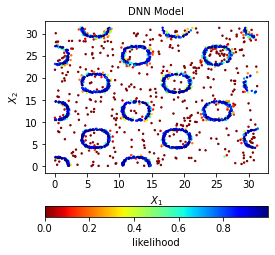

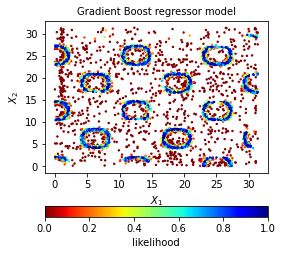

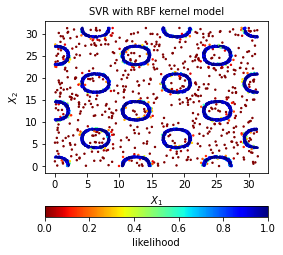

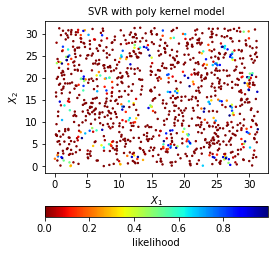

In [9]:
model.plot_model(output_dd,'DNN Model')
model.plot_model(output_GB,'Gradient Boost regressor model')
model.plot_model(output_RBF,'SVR with RBF kernel model')
model.plot_model(output_POLY,'SVR with poly kernel model')